# **Phân tích cổ phiếu Visa(mã cổ phiếu:V)**

**Import các thư viện cần thiết**

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
!"{sys.executable}" -m pip install ta
from ta.momentum import RSIIndicator
from ta.trend import MACD

## 1.Lấy dữ liệu

In [160]:
# Lấy dữ liệu 2 năm gần nhất
symbol = "V"
stock = yf.Ticker(symbol)
start_date = '2023-01-01'
end_date = '2025-06-14'

df = stock.history(start = start_date, end = end_date).reset_index()


In [161]:
df.drop(['Dividends', 'Stock Splits'], axis= 1, inplace= True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2023-01-03 00:00:00-05:00,205.368930,208.361934,202.307242,203.514252,4202800
1,2023-01-04 00:00:00-05:00,205.702561,209.215659,205.702561,208.636688,6606200
2,2023-01-05 00:00:00-05:00,209.804465,210.157738,206.526887,207.164734,5246000
3,2023-01-06 00:00:00-05:00,210.000729,214.063360,209.107732,213.680649,6829700
4,2023-01-09 00:00:00-05:00,214.976004,218.057322,214.269458,214.514786,6294500


In [162]:
# Xuất dữ liệu gốc
df.to_csv("visa_raw.csv", index=False)

### Đồ thị biểu diễn giá cổ phiếu

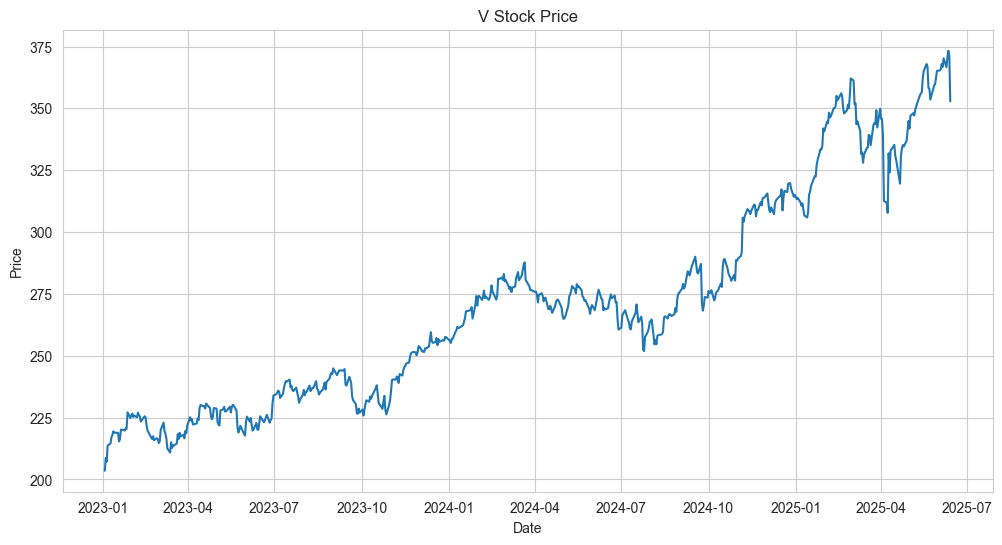

In [163]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Close')
plt.title(f'{symbol} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

## 2. Làm sạch & Tiền xử lí

### 2.1. Drop missing value

In [164]:
df_clean = df.dropna().reset_index(drop= True)

### 2.2. Loại bỏ outliers

#### A, Z-score

In [165]:
# TÍnh trung bình & độ lệch chuẩn của Close
m, sigma = df_clean['Close'].mean(), df_clean['Close'].std()

# Tính Z-score
df_clean['z_score'] = (df_clean['Close'] - m) / sigma

# Lọc
df= df_clean[np.abs(df_clean['z_score']) <= 3].reset_index(drop= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype                           
---  ------   --------------  -----                           
 0   Date     614 non-null    datetime64[ns, America/New_York]
 1   Open     614 non-null    float64                         
 2   High     614 non-null    float64                         
 3   Low      614 non-null    float64                         
 4   Close    614 non-null    float64                         
 5   Volume   614 non-null    int64                           
 6   z_score  614 non-null    float64                         
dtypes: datetime64[ns, America/New_York](1), float64(5), int64(1)
memory usage: 33.7 KB


#### B, IQR

In [166]:
# Tính Q1,Q3,IQR
Q1 = df['Close'].quantile(0.25)
Q3 = df['Close'].quantile(0.75)
IQR = Q3 - Q1

#Xác định ngưỡng
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc
df_iqr = df[df['Close'].between(lower_bound,upper_bound)]
df_iqr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 613 entries, 0 to 613
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype                           
---  ------   --------------  -----                           
 0   Date     613 non-null    datetime64[ns, America/New_York]
 1   Open     613 non-null    float64                         
 2   High     613 non-null    float64                         
 3   Low      613 non-null    float64                         
 4   Close    613 non-null    float64                         
 5   Volume   613 non-null    int64                           
 6   z_score  613 non-null    float64                         
dtypes: datetime64[ns, America/New_York](1), float64(5), int64(1)
memory usage: 38.3 KB


### 2.3. Chuyển định dạng date time


In [167]:
# Đảm bảo Date đúng kiểu & drop duplicate theo date
df.drop_duplicates(subset= 'Date')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,z_score
0,2023-01-03 00:00:00-05:00,205.368930,208.361934,202.307242,203.514252,4202800,-1.581470
1,2023-01-04 00:00:00-05:00,205.702561,209.215659,205.702561,208.636688,6606200,-1.461262
2,2023-01-05 00:00:00-05:00,209.804465,210.157738,206.526887,207.164734,5246000,-1.495804
3,2023-01-06 00:00:00-05:00,210.000729,214.063360,209.107732,213.680649,6829700,-1.342895
4,2023-01-09 00:00:00-05:00,214.976004,218.057322,214.269458,214.514786,6294500,-1.323321


In [168]:
# Xuất dữ liệu sau khi làm sạch
df_clean = df
df_clean.to_csv("visa_clean.csv", index=False)

## 3. Chỉ số kĩ thuật

### 3.1. SMA

In [169]:
df['SMA20'] = df['Close'].rolling(window= 20).mean()
df['SMA50'] = df['Close'].rolling(window= 50).mean()

df.tail()

,Date,Open,High,Low,Close,Volume,z_score,SMA20,SMA50
609,2025-06-09 00:00:00-04:00,369.790009,369.790009,362.049988,366.660004,4999900,2.247062,362.463998,346.706586
610,2025-06-10 00:00:00-04:00,367.000000,371.440002,366.679993,370.700012,4109300,2.341869,363.235999,347.274955
611,2025-06-11 00:00:00-04:00,370.000000,375.510010,369.380005,373.309998,5562700,2.403117,364.094498,347.743577
612,2025-06-12 00:00:00-04:00,372.230011,374.170013,369.549988,371.399994,4874000,2.358296,364.841498,348.256061
613,2025-06-13 00:00:00-04:00,361.510010,363.010010,345.000000,352.850006,14181700,1.922984,364.368999,348.397946


### 3.2. EMA

In [170]:
df['EMA20'] = df['Close'].ewm(span= 20, min_periods= 20).mean()
df.head(20)

,Date,Open,High,Low,Close,Volume,z_score,SMA20,SMA50,EMA20
0,2023-01-03 00:00:00-05:00,205.368930,208.361934,202.307242,203.514252,4202800,-1.581470,NaN,NaN,NaN
1,2023-01-04 00:00:00-05:00,205.702561,209.215659,205.702561,208.636688,6606200,-1.461262,NaN,NaN,NaN
2,2023-01-05 00:00:00-05:00,209.804465,210.157738,206.526887,207.164734,5246000,-1.495804,NaN,NaN,NaN
3,2023-01-06 00:00:00-05:00,210.000729,214.063360,209.107732,213.680649,6829700,-1.342895,NaN,NaN,NaN
4,2023-01-09 00:00:00-05:00,214.976004,218.057322,214.269458,214.514786,6294500,-1.323321,NaN,NaN,NaN
5,2023-01-10 00:00:00-05:00,214.897491,218.233945,214.102616,216.958237,10857000,-1.265980,NaN,NaN,NaN
6,2023-01-11 00:00:00-05:00,217.154481,218.027848,215.594199,217.949356,5408200,-1.242722,NaN,NaN,NaN
7,2023-01-12 00:00:00-05:00,217.949365,219.627400,216.487205,219.440948,4264400,-1.207719,NaN,NaN,NaN
8,2023-01-13 00:00:00-05:00,217.762916,219.578334,216.025990,218.891418,4283200,-1.220615,NaN,NaN,NaN
9,2023-01-17 00:00:00-05:00,218.224126,220.206365,218.214304,218.832535,6101100,-1.221996,NaN,NaN,NaN


### 3.3. RSI

In [171]:
rsi_indicator = RSIIndicator(close= df['Close'], window= 14)
df['RSI14'] = rsi_indicator.rsi()
print(df[['Date', 'Close', 'RSI14']].head(15))

                        Date       Close      RSI14
0  2023-01-03 00:00:00-05:00  203.514252        NaN
1  2023-01-04 00:00:00-05:00  208.636688        NaN
2  2023-01-05 00:00:00-05:00  207.164734        NaN
3  2023-01-06 00:00:00-05:00  213.680649        NaN
4  2023-01-09 00:00:00-05:00  214.514786        NaN
5  2023-01-10 00:00:00-05:00  216.958237        NaN
6  2023-01-11 00:00:00-05:00  217.949356        NaN
7  2023-01-12 00:00:00-05:00  219.440948        NaN
8  2023-01-13 00:00:00-05:00  218.891418        NaN
9  2023-01-17 00:00:00-05:00  218.832535        NaN
10 2023-01-18 00:00:00-05:00  215.358704        NaN
11 2023-01-19 00:00:00-05:00  216.290924        NaN
12 2023-01-20 00:00:00-05:00  220.118057        NaN
13 2023-01-23 00:00:00-05:00  219.990479  76.396149
14 2023-01-24 00:00:00-05:00  219.705902  75.033583


### 3.4. MACD

In [172]:
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

### **Biểu đồ giá đóng cửa kèm chỉ số kĩ thuật**

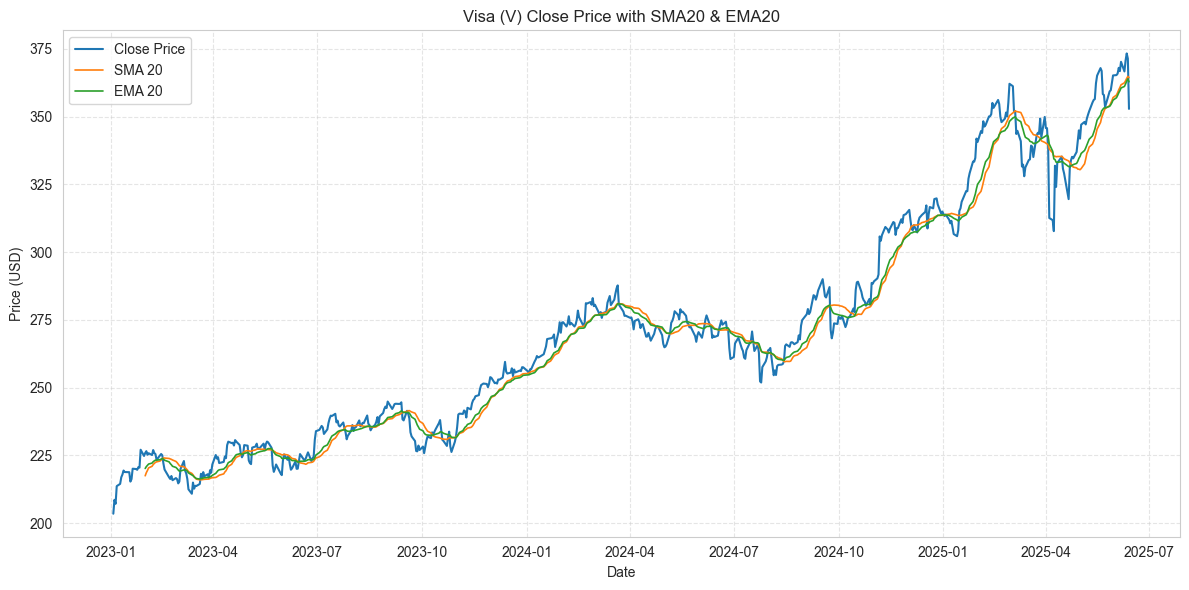

In [173]:
# 1. Thiết lập style cho Seaborn
sns.set_style('whitegrid')

# 2. Tạo Figure và Axes
plt.figure(figsize=(12, 6))

# 3. Vẽ giá đóng cửa (Close)
plt.plot(
    df['Date'],                    
    df['Close'],                  
    label='Close Price',           
    linewidth=1.5,                
    color='tab:blue'            
)
# 4. Vẽ SMA20
plt.plot(
    df['Date'],                   
    df['SMA20'],                  
    label='SMA 20',              
    linewidth=1.2,    
    color='tab:orange'            
)
# 5. Vẽ EMA20
plt.plot(
    df['Date'],
    df['EMA20'],
    label='EMA 20',
    linewidth=1.2,
    color='tab:green'       
)

# 6. Thêm tiêu đề và nhãn trục
plt.title('Visa (V) Close Price with SMA20 & EMA20') 
plt.xlabel('Date')                   
plt.ylabel('Price (USD)')           
# 7. Hiển thị legend
plt.legend(loc='upper left')        
# 8. Bật lưới (grid)
plt.grid(True, linestyle='--', alpha=0.5)  

# 9. Tối ưu layout và show
plt.tight_layout()                
plt.show()                          

### *Biểu đồ MACD*

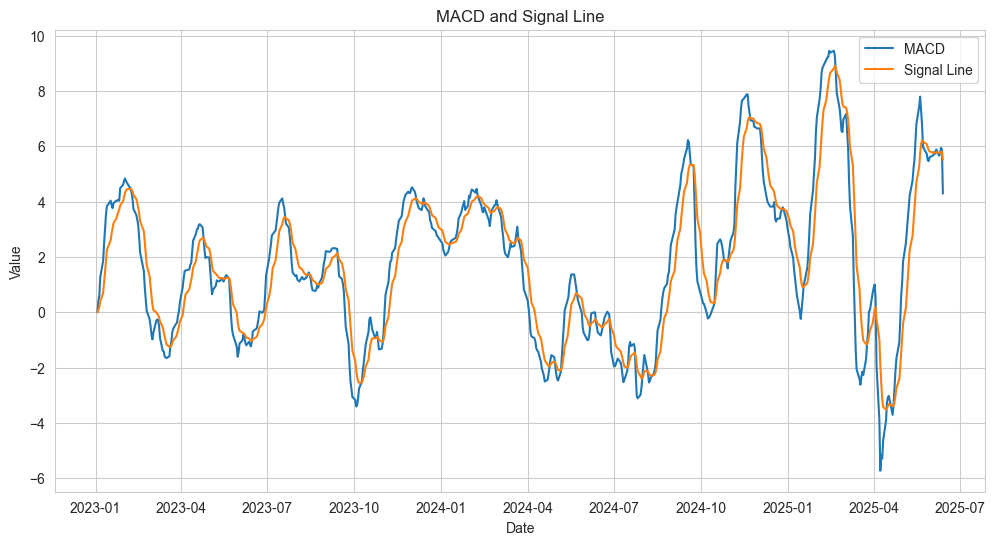

In [174]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'],df['MACD'], label='MACD')
plt.plot(df['Date'],df['Signal_Line'], label='Signal Line')
plt.title('MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

### Biểu đồ RSI

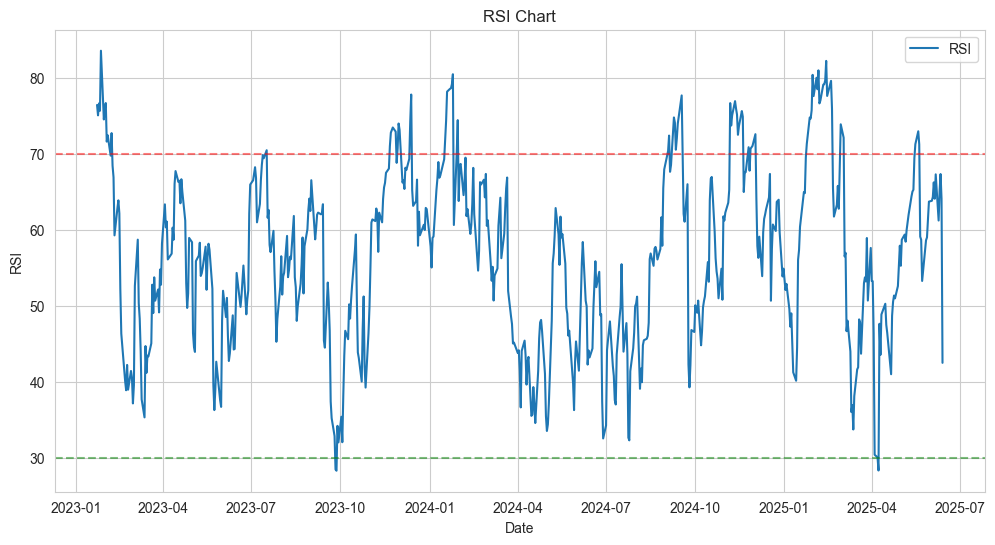

In [175]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'],df['RSI14'], label='RSI')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')
plt.axhline(30, linestyle='--', alpha=0.5, color='green')
plt.title('RSI Chart')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()

## 4. Phân tích dữ liệu

### 4.1. Tính lợi suất ngày & phân phối lợi suất

In [176]:
df['Return'] = df['Close'].pct_change()
df.head()

,Date,Open,High,Low,Close,Volume,z_score,SMA20,SMA50,EMA20,RSI14,MACD,Signal_Line,Return
0,2023-01-03 00:00:00-05:00,205.368930,208.361934,202.307242,203.514252,4202800,-1.581470,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,2023-01-04 00:00:00-05:00,205.702561,209.215659,205.702561,208.636688,6606200,-1.461262,NaN,NaN,NaN,NaN,0.408627,0.081725,0.025170
2,2023-01-05 00:00:00-05:00,209.804465,210.157738,206.526887,207.164734,5246000,-1.495804,NaN,NaN,NaN,NaN,0.606700,0.186720,-0.007055
3,2023-01-06 00:00:00-05:00,210.000729,214.063360,209.107732,213.680649,6829700,-1.342895,NaN,NaN,NaN,NaN,1.274758,0.404328,0.031453
4,2023-01-09 00:00:00-05:00,214.976004,218.057322,214.269458,214.514786,6294500,-1.323321,NaN,NaN,NaN,NaN,1.850180,0.693498,0.003904


#### *Biểu đồ Histogram của lợi suất*

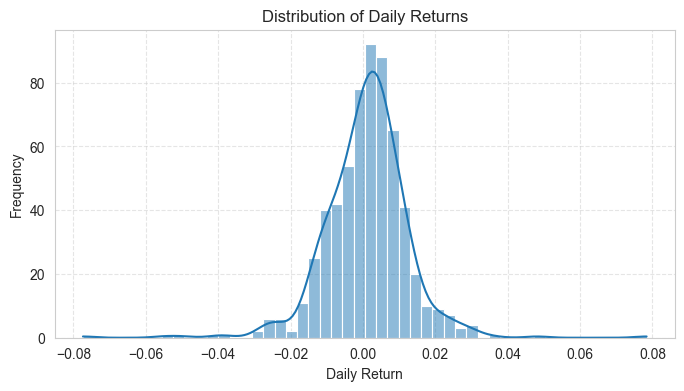

In [177]:
returns = df['Return'].dropna()
plt.figure(figsize=(8,4))
sns.histplot(returns, bins=50, kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True, ls='--', alpha=0.5)
plt.show()

### 4.2. Tính volatility

In [ ]:
# Tính volativity theo thángx   
df['YearMonth'] = df['Date'].dt.to_period('M')
vol_monthly = (df.groupby('YearMonth')['Return'].std().reset_index().rename(columns= {'Return' : 'Volatility'}))

vol_monthly['YearMonth'] = vol_monthly['YearMonth'].dt.to_timestamp()

#### *Biểu đồ volatility*

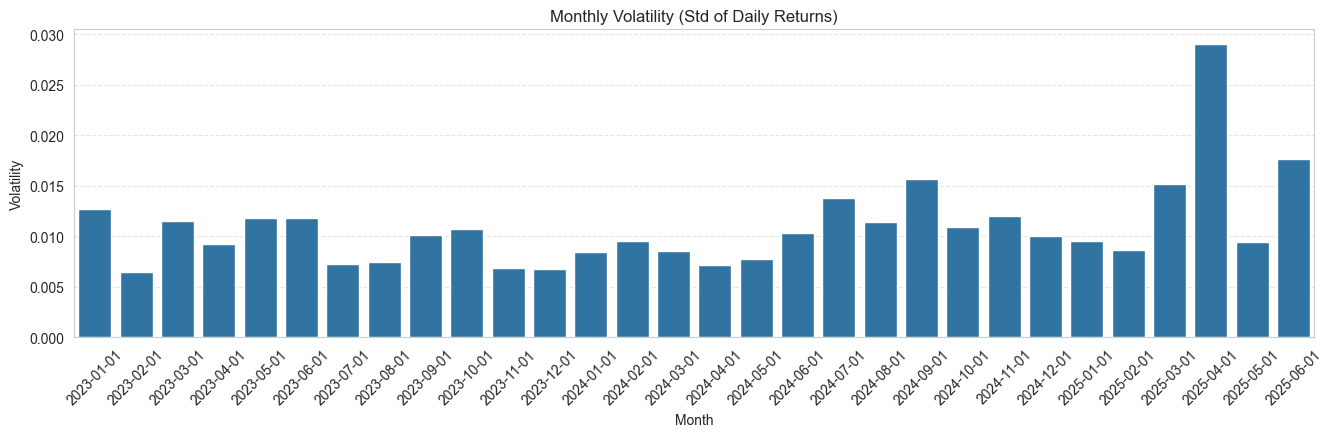

In [179]:
plt.figure(figsize=(16,4))
sns.barplot(data=vol_monthly, x='YearMonth', y='Volatility')
plt.xticks(rotation=45)
plt.title('Monthly Volatility (Std of Daily Returns)')
plt.xlabel('Month')
plt.ylabel('Volatility')
plt.grid(axis='y', ls='--', alpha=0.5)
plt.show()

### 4.3 Phân tích tương quan giá đóng và các chỉ số

In [180]:
# Chọn cột và drop NaN(Do chỉ số NaN ở đầu)
cols = ['Close','SMA20','EMA20','RSI14']
df_corr = df[cols].dropna()

# Tính ma trận tương quan
corr_matrix = df_corr.corr()
corr_matrix

,Close,SMA20,EMA20,RSI14
Close,1.000000,0.986033,0.990186,0.281689
SMA20,0.986033,1.000000,0.999194,0.136027
EMA20,0.990186,0.999194,1.000000,0.157163
RSI14,0.281689,0.136027,0.157163,1.000000


#### *Heat map ma trận tương quan*

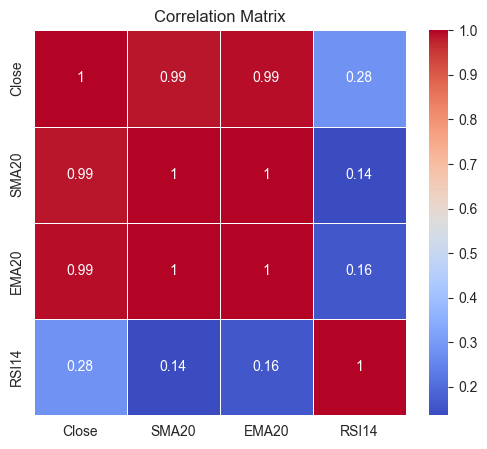

In [181]:
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot= True, cmap= 'coolwarm',linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## 5. Diễn giải & Kết luận

### 5.1. Xu hướng chính
- Trong giai đoạn **01/01/2023 – 14/06/2025**, giá cổ phiếu **V (Visa)** đã **tăng** từ khoảng **229$** (ngày đầu) lên **353$** (ngày cuối), tương ứng tổng lợi suất khoảng **154 %**.
- Đường **SMA20** và **EMA20** phần lớn nằm dưới giá đóng, cho thấy xu hướng **tăng** chung.
- Ví dụ: khi giá cắt lên SMA20 vào khoảng tháng **11/2023**, sau đó tiếp tục đi lên → xác nhận tín hiệu tăng.

### 5.2.Giai đoạn biến động cao
- Tháng **04/2025** có độ biến động (volatility) lớn nhất, khoảng **3%** (độ lệch chuẩn của daily return).  
- Nguyên nhân khả thi:
    - Bất ngờ tích cực về kết quả kinh doanh Q2, với chỉ số tài chính vượt kỳ vọng.
    - Chương trình mua lại cổ phiếu quy mô, tác động mạnh lên cung cầu trên thị trường.
    - Source: 
        - https://www.investors.com/research/investing-action-plan/stock-market-trade-war-tesla-google-boeing-earnings/
        - https://www.reuters.com/business/finance/visa-quarterly-profit-rises-strong-card-spending-volumes-2025-04-29/
- Phần lớn các tháng đều có volatility ổn định dưới **1% - 1.5%**, thị trường tương đối ổn định, ít dao động lớn.

### 5.3. Đề xuất khuyến nghị đầu tư cơ bản
- **Mua (Entry) khi**:  
  1. Giá cắt lên EMA20 kèm volume tăng đột biến.  
  2. RSI đang ở vùng **40–50** (không quá mua, vẫn có dư địa tăng).  
  3. Giá chạm vùng hỗ trợ gần SMA50.

- **Bán (Exit) khi**:  
  1. RSI vượt **70** và giá chững lại hoặc hình thành nến đảo chiều.  
  2. Giá cắt xuống SMA20 → cảnh báo xu hướng tăng ngắn hạn suy yếu.  
  3. Volatility đột biến cao , có thể do tin bất ngờ.

- **Giữ (Hold) khi**:  
  - Giá nằm giữa EMA20 và SMA50, RSI dao động trong **45–55**, volatility thấp → thị trường sideway.

---
> **Tóm lại**, trong năm vừa qua, cổ phiếu V cho tín hiệu xu hướng **tăng tổng thể**, với các giai đoạn biến động đỉnh điểm vào tháng **04/2025**. SMA/EMA giúp xác nhận trend, RSI cho điểm overbought/oversold, và volatility cho biết rủi ro dao động. Kết hợp các chỉ số này, nhà đầu tư có thể **mua** khi giá cắt lên EMA20 + RSI < 50, và **bán** khi RSI > 70 hoặc giá xuyên SMA20.
